# Model Order Selection for Hidden Markov Models

https://hal.archives-ouvertes.fr/hal-00706781/document

The problem of estimating the number of hidden states in a hidden Markov model is considered. The most common approach for model order selection involves selecting a model order that minimises one or more information criteria evaluated over a range of model orders. Commonly used information criteria include Akaike Information Criterion (AIC) and the Bayesian Information Criterion (BIC) and many others. We implemented these two. 

The Akaike Information Criterion for HMMs can be defined as $AIC = −2ln(V) + 2k$, where $k$ is the number of free parameters, $2k$ is the penalty, $V$ is the likelihood. The best model is the one which has the weakest AIC.

The Bayesian Information Criterion $BIC = −2ln(V) + kln(n)$, where $k$ is the number of free parameters, $n$ is the number of data and $kln(n)$ is the
penalty term.  The best model is the one which gets the minimum value of BIC.

These to criteria are often used together, because they both penalise models with too many parameters, however BIC penalises model complexity more heavily. 

In [1]:
 # path settings
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pickle

from src.GaussianHMM import GaussianHMM
from src.DiscreteHMM import MultinomialHMM
from src.HeterogeneousHMM import HeterogeneousHMM
import src.utils as su
import src.model_order_selection_utils as mos

%load_ext autoreload
%autoreload 2

# Gaussian HMM

Source of example: https://hmmlearn.readthedocs.io/en/0.2.0/auto_examples/plot_hmm_sampling.html#sphx-glr-auto-examples-plot-hmm-sampling-py. 

Consider an HMM with Gaussian emissions, 4 hidden states with specified mean and covariance. The following figure shows shows some samples drawn from the model with the corresponding transitions. 

<img src="img/gauss_hmm_samples.png" width="600"/>

We will use the generated samples to train GHMMs with different number of states and compute the model order selection criteria. 

In [2]:
# instantiate a MultinomialHMM object
my_hmm = GaussianHMM(
    n_states=4,
    n_emissions=2,
    covariance_type="diagonal"
)

# we set model parameters according to the example
# the initial state probabilities, array of shape (n_states, )
my_hmm.pi = np.array([0.6, 0.3, 0.1, 0.0])
# the state transition probabilities, array of shape (n_states, n_states)
my_hmm.A = np.array(
    [
        [0.7, 0.2, 0.0, 0.1],
        [0.3, 0.5, 0.2, 0.0],
        [0.0, 0.3, 0.5, 0.2],
        [0.2, 0.0, 0.2, 0.6],
    ]
)
# the means of each component
my_hmm.means = np.array([[0.0, 0.0], [0.0, 11.0], [9.0, 10.0], [11.0, -1.0]])

# the covariance of each component - shape depends `covariance_type`
#             (n_states, )                          if "spherical",
#             (n_states, n_emissions)               if "diagonal",
#             (n_states, n_emissions, n_emissions)  if "full"
#             (n_emissions, n_emissions)            if "tied"
my_hmm.covars = 0.5 * np.ones((4, 2))  # diagonal covariance matrix

su.pretty_print_hmm(my_hmm, hmm_type="Gaussian")

Priors
+--------------+--------------+--------------+--------------+
|     S_0      |     S_1      |     S_2      |     S_3      |
+--------------+--------------+--------------+--------------+
| P(S_0)=0.600 | P(S_1)=0.300 | P(S_2)=0.100 | P(S_3)=0.000 |
+--------------+--------------+--------------+--------------+
Transitions
+-----+------------------+------------------+------------------+------------------+
|  _  |       S_0        |       S_1        |       S_2        |       S_3        |
+-----+------------------+------------------+------------------+------------------+
| S_0 | P(S_0|S_0)=0.700 | P(S_1|S_0)=0.200 | P(S_2|S_0)=0.000 | P(S_3|S_0)=0.100 |
| S_1 | P(S_0|S_1)=0.300 | P(S_1|S_1)=0.500 | P(S_2|S_1)=0.200 | P(S_3|S_1)=0.000 |
| S_2 | P(S_0|S_2)=0.000 | P(S_1|S_2)=0.300 | P(S_2|S_2)=0.500 | P(S_3|S_2)=0.200 |
| S_3 | P(S_0|S_3)=0.200 | P(S_1|S_3)=0.000 | P(S_2|S_3)=0.200 | P(S_3|S_3)=0.600 |
+-----+------------------+------------------+------------------+------------------+

In [8]:
# generate observation sequences of different lengths
lengths = np.random.randint(25, 150, size=50)
X = [
    my_hmm.sample(n_sequences=1, n_samples=n_samples)[0][0] for n_samples in lengths
]

# train models with different number of states and evaluate the model order selection criteria to decide which match best
n_states = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
n_samples = sum(lengths)
models = []
criteria = {"AIC": np.zeros_like(n_states), "BIC": np.zeros_like(n_states)}
for idx, ns in enumerate(n_states):
    # initialise model
    temp_ghmm = GaussianHMM(
        # number of hidden states
        n_states=ns,
        # number of distinct emissions
        n_emissions=2,
        # initialisation type can be "random", "kmeans"
        init_type="kmeans",
        # can be "diagonal", "full", "spherical", "tied"
        covariance_type="diagonal",
        verbose=False
    )

    # train the model to estimate the parameters
    temp_ghmm, log_likelihood = temp_ghmm.train(
        X,
        n_init=1,     # number of initialisations to perform
        n_iter=100,   # maximum number of iterations to run
        thres=0.001,  # what percentage of change in the log-likelihood between iterations is considered convergence
        conv_iter=5,  # for how many iterations does it have to hold
        # whether to plot the evolution of the log-likelihood over the iterations
        plot_log_likelihood=False,
        # set to True if want to train until maximum number of iterations is reached
        ignore_conv_crit=False,
        no_init=False,  # set to True if the model parameters shouldn't be re-initialised befor training; in this case they have to be set manually first, otherwise errors occur
    )

    # compute the number of free parameters of the model
    dof = mos.get_n_fit_scalars(temp_ghmm)

    # compute the model order selection criterias
    aic = mos.aic_hmm(log_likelihood, dof)
    criteria["AIC"][idx] = aic

    bic = mos.bic_hmm(log_likelihood, n_samples, dof)
    criteria["BIC"][idx] = bic
    
    print("{} states: logL = {:.3f}, AIC = {:.3f}, BIC = {:.3f}".format(ns, log_likelihood, aic, bic))

1 states: logL = -25279.476, AIC = 50570.951, BIC = 57926.666
2 states: logL = -19795.062, AIC = 39618.124, BIC = 50441.928
3 states: logL = -17705.407, AIC = 35458.814, BIC = 48478.971
4 states: logL = -12821.195, AIC = 25714.390, BIC = 40377.820
5 states: logL = -12892.719, AIC = 25885.437, BIC = 41871.676
6 states: logL = -12967.288, AIC = 26066.577, BIC = 43162.437
7 states: logL = -13035.812, AIC = 26239.624, BIC = 44291.142
8 states: logL = -13158.457, AIC = 26524.914, BIC = 45414.650
9 states: logL = -13272.394, AIC = 26796.788, BIC = 46431.579
10 states: logL = -13337.733, AIC = 26975.465, BIC = 47279.197


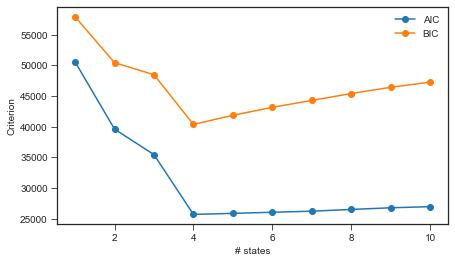

In [9]:
# plot the model order selection criteria in function of the number of states
mos.plot_model_selection(n_states, criteria)

If we look at the plot, we can see that the best AIC and BIC scores where reached when the number of states in the model was four, just like the generator model. 